# Подготовка окружения и конфигурации

In [1]:
import numpy as np
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
from dataset import MultimodalDataset, get_transforms, collate_fn
import timm
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader

from torchmetrics.regression import MeanAbsoluteError

In [2]:
class Config:
    # для воспроизводимости
    SEED = 42

    # Модели
    TEXT_MODEL_NAME = "bert-base-uncased"
    IMAGE_MODEL_NAME = "tf_efficientnet_b0"

    # Какие слои размораживаем - совпадают с нэймингом в моделях
    #TEXT_MODEL_UNFREEZE = "encoder.layer.11|pooler"
    #IMAGE_MODEL_UNFREEZE = "blocks.6|conv_head|bn2"
    # TEXT_MODEL_UNFREEZE = ""
    IMAGE_MODEL_UNFREEZE = ""

    NUM_INGR = ""
    EMB_INGR = 32

    MASS_MEAN = ""
    MASS_STD = ""
    
    # Гиперпараметры
    # BATCH_SIZE = 256
    BATCH_SIZE = 64
    IMAGE_LR = 1e-4
    EMB_INGR_LR = 1e-3
    CLASSIFIER_LR = 1e-3
    EPOCHS = 30
    DROPOUT = 0.3
    HUBER_DELTA=30.0


    # Пути
    DF_PATH = "data/dish.csv"
    IMG_PATH = "data/images/"
    SAVE_PATH = "best_model.pth"

cfg = Config()
device = "cuda" if torch.cuda.is_available() else "cpu"
print('device: ', device)

device:  cuda


In [3]:
transforms = get_transforms(cfg)

# Пример инстанса данных тестового сета

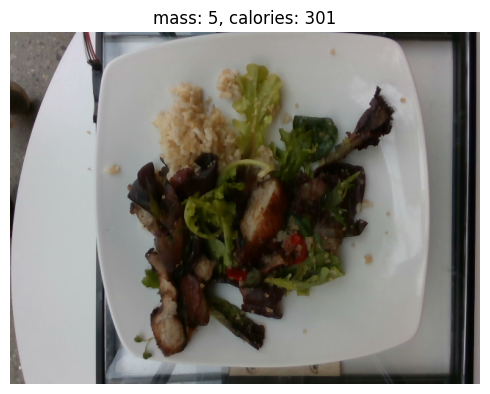

ingridients:  tensor([164,  67,  21, 179,  59,  19,  87,  45,  24, 117, 109, 175,  80, 152,
        180, 113, 168])


In [4]:
ds = MultimodalDataset(cfg, transforms, ds_type="test", initial_img=True)
item = ds[0]
initial_image = item["initial_image"]

plt.figure(figsize=(5, 5)) 

plt.imshow(initial_image)
plt.title(f"mass: {item["mass"]:.0f}, calories: {item["label"]:.0f}")
plt.axis('off')
plt.tight_layout()
plt.show()
print("ingridients: ", item["ingr_idxs"])
# del ds

In [5]:
class MultimodalModel(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.image_model = timm.create_model(
            config.IMAGE_MODEL_NAME,
            pretrained=True,
            num_classes=0
        )

        self.mass_mean = config.MASS_MEAN
        self.mass_std = config.MASS_STD

        self.ingr_embed = nn.Embedding(config.NUM_INGR + 1, config.EMB_INGR, padding_idx=0)
        conc_shape = self.image_model.num_features + config.EMB_INGR + 1
        self.regressor = nn.Sequential(
            nn.Linear(conc_shape, conc_shape // 2),
            nn.LayerNorm(conc_shape // 2),
            nn.ReLU(),
            nn.Dropout(config.DROPOUT),
            nn.Linear(conc_shape // 2, 1)
        )

    def forward(self, image, ingr_idxs, mass):
        img_emb = self.image_model(image)
        ingr_emb = self.ingr_embed(ingr_idxs)
        ingr_mask = (ingr_idxs != 0).unsqueeze(-1) 
        ingr_emb = (ingr_emb * ingr_mask).sum(dim=1) #/ ingr_mask.sum(dim=1).clamp(min=1)

        mass_norm = (mass - self.mass_mean) / self.mass_std 
        x = torch.cat([img_emb, ingr_emb, mass_norm.unsqueeze(-1)], dim=1)
        return self.regressor(x).squeeze(-1)

In [6]:
model = MultimodalModel(cfg).to(device)

def set_requires_grad(module: nn.Module, unfreeze_pattern="", verbose=False):
    if len(unfreeze_pattern) == 0:
        for _, param in module.named_parameters():
            param.requires_grad = False
        return

    pattern = unfreeze_pattern.split("|")

    for name, param in module.named_parameters():
        if any([name.startswith(p) for p in pattern]):
            param.requires_grad = True
            if verbose:
                print(f"Разморожен слой: {name}")
        else:
            param.requires_grad = False

set_requires_grad(model.image_model, cfg.IMAGE_MODEL_UNFREEZE)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Обучаемых параметров: {count_parameters(model):,}")

Обучаемых параметров: 870,321


In [7]:
optimizer = AdamW([{
        'params': model.image_model.parameters(),
        'lr': cfg.IMAGE_LR
    }, {
        'params': model.ingr_embed.parameters(),
        'lr': cfg.EMB_INGR_LR
    }, {
        'params': model.regressor.parameters(),
        'lr': cfg.CLASSIFIER_LR
    }])

criterion = nn.HuberLoss(delta=cfg.HUBER_DELTA)

In [8]:
train_dataset = MultimodalDataset(cfg, transforms, ds_type="train")
val_dataset = MultimodalDataset(cfg, transforms, ds_type="test")
train_loader = DataLoader(train_dataset,
                              batch_size=cfg.BATCH_SIZE,
                              shuffle=True,
                              collate_fn=collate_fn)
val_loader = DataLoader(val_dataset,
                              batch_size=cfg.BATCH_SIZE,
                              shuffle=False,
                              collate_fn=collate_fn)

In [9]:
def print_gpu_memory():
    '''контроль загрузки видеопамяти'''
    if torch.cuda.is_available():
        for i in range(torch.cuda.device_count()):
            total_memory = torch.cuda.get_device_properties(i).total_memory /1024**3
            allocated = torch.cuda.memory_allocated(i) / 1024**3 
            reserved = torch.cuda.memory_reserved(i) / 1024**3 
            max_allocated = torch.cuda.max_memory_allocated(i) / 1024**3
            utilization = allocated / total_memory * 100
            max_utilization = max_allocated / total_memory * 100
            print(f'\nGPU {i}====>')
            print(f'total mem    : {total_memory:.2f} GB')
            print(f'!current mem : {allocated:.2f} GB ({utilization:.1f}%)')
            print(f'reserved mem : {reserved:.2f} GB')
            print(f'!max per epoch: {max_allocated:.2f} GB ({max_utilization:.1f}%)')
            print(f'=====>GPU {i}\n')
            torch.cuda.reset_peak_memory_stats()
    else:
        print('cuda не доступна')

epoch_mae = MeanAbsoluteError().to(device)
batch_mae = MeanAbsoluteError().to(device)

In [ ]:
def validate(model, val_loader, epoch_index):
    model.eval()
    epoch_mae.reset()
    total_loss = 0.0
    samples = 0.0

    progress_bar = tqdm(
                val_loader,
                desc=f"{'  val epoch ' + str(epoch_index+1):<15}",
            )

    with torch.no_grad():
        for batch in progress_bar:
            batch_mae.reset()
            inputs = {
                'image': batch['image'].to(device),
                'ingr_idxs': batch['ingr_idxs'].to(device),
                'mass': batch['mass'].to(device)
            }
            labels = batch['label'].to(device)

            predicted = model(**inputs)
            loss = criterion(predicted, labels)
            total_loss += loss.item()*len(labels)
            samples += len(labels)
            
            epoch_mae.update(predicted, labels)    
            batch_mae.update(predicted, labels)    
            val_batch_mae = batch_mae.compute().item()
            progress_bar.set_postfix(
            {
                'last batch loss': f'{loss.item():.1f}',
                'last batch mae': f'{val_batch_mae:.1f}'
             }
             )
    
    val_epoch_mae = epoch_mae.compute().item()
    return  val_epoch_mae, total_loss / samples

def train_one_epoch(model, train_loader, val_loader, epoch_index=0):
    model.train()
    epoch_mae.reset()
    total_loss = 0.0
    samples = 0.0

    progress_bar = tqdm(
                train_loader,
                desc=f"{'train epoch ' + str(epoch_index+1):<15}",
            )

    for batch in progress_bar:
        batch_mae.reset()
        inputs = {
            'image': batch['image'].to(device),
            'ingr_idxs': batch['ingr_idxs'].to(device),
            'mass': batch['mass'].to(device)
        }
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        predicted = model(**inputs)
        loss = criterion(predicted, labels)

        total_loss += loss.item()*len(labels)
        samples += len(labels)
        epoch_mae.update(predicted, labels)
        batch_mae.update(predicted, labels)
        train_batch_mae = batch_mae.compute().item()

        progress_bar.set_postfix(
            {
                'last batch loss': f'{loss.item():.1f}',
                'last batch mae': f'{train_batch_mae:.1f}'
             }
             )
        
        loss.backward()
        optimizer.step()

    train_epoch_loss = total_loss / samples
    train_epoch_mae = epoch_mae.compute().item()
    val_epoch_mae, val_epoch_loss = validate(model,val_loader, epoch_index)
    #print_gpu_memory()
    print(f"{'total epoch ' + str(epoch_index+1):<15}", f'train loss {train_epoch_loss:.1f}, val loss {val_epoch_loss:.1f}', f'train mae {train_epoch_mae:.1f}, val mae {val_epoch_mae:.1f}')
    print('-'*40)
    return train_epoch_loss, train_epoch_mae, val_epoch_loss, val_epoch_mae

In [ ]:
def plot_training_history(train_losses, val_losses, train_maes, val_maes):
    """
    Построение графиков обучения
    
    Parameters:
    -----------
    train_losses : list
        Значения loss на тренировочных данных по эпохам
    val_losses : list
        Значения loss на валидационных данных по эпохам
    train_maes : list
        Значения MAE на тренировочных данных по эпохам
    val_maes : list
        Значения MAE на валидационных данных по эпохам
    save_path : str, optional
        Путь для сохранения графика
    """
    print("\n" + "="*100)
    epochs = range(1, len(train_losses) + 1)
    
    # Создаем фигуру с двумя subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 1. График Loss
    ax1 = axes[0]
    ax1.plot(epochs, train_losses, 'b-', linewidth=2, label='Train Loss', alpha=0.8)
    ax1.plot(epochs, val_losses, 'r-', linewidth=2, label='Val Loss', alpha=0.8)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Train and Validation Loss', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=11)
    
    # Отмечаем лучшую эпоху по val loss
    best_epoch_loss = np.argmin(val_losses) + 1
    best_val_loss = min(val_losses)
    ax1.axvline(x=best_epoch_loss, color='r', linestyle='--', alpha=0.5, 
                label=f'Best epoch: {best_epoch_loss}')
    ax1.scatter(best_epoch_loss, best_val_loss, color='r', s=100, zorder=5)
    ax1.legend(fontsize=11)
    
    # 2. График MAE
    ax2 = axes[1]
    ax2.plot(epochs, train_maes, 'b-', linewidth=2, label='Train MAE', alpha=0.8)
    ax2.plot(epochs, val_maes, 'r-', linewidth=2, label='Val MAE', alpha=0.8)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.set_ylabel('MAE', fontsize=12)
    ax2.set_title('Train and Validation MAE', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=11)
    
    # Отмечаем лучшую эпоху по val MAE
    best_epoch_mae = np.argmin(val_maes) + 1
    best_val_mae = min(val_maes)
    ax2.axvline(x=best_epoch_mae, color='r', linestyle='--', alpha=0.5,
                label=f'Best epoch: {best_epoch_mae}')
    ax2.scatter(best_epoch_mae, best_val_mae, color='r', s=100, zorder=5)
    ax2.legend(fontsize=11)
    
    # Настройка общего вида
    plt.tight_layout()
    
    plt.show()
    
    # Вывод статистики
    print("\n" + "="*50)
    print("ТРЕНИРОВОЧНАЯ СТАТИСТИКА:")
    print("="*50)
    print(f"Финальный Train Loss: {train_losses[-1]:.4f}")
    print(f"Финальный Val Loss:   {val_losses[-1]:.4f}")
    print(f"Финальный Train MAE:  {train_maes[-1]:.4f}")
    print(f"Финальный Val MAE:    {val_maes[-1]:.4f}")
    print(f"\nЛучшая Val Loss:     {best_val_loss:.4f} (эпоха {best_epoch_loss})")
    print(f"Лучшая Val MAE:      {best_val_mae:.4f} (эпоха {best_epoch_mae})")
    print("\n" + "="*100)

  val epoch 1  : 100%|██████████| 8/8 [00:14<00:00,  1.83s/it, last batch loss=5106.6, last batch mae=184.1]



GPU 0====>
total mem    : 1.95 GB
!current mem : 0.05 GB (2.4%)
reserved mem : 1.26 GB
!max per epoch: 0.88 GB (45.0%)
=====>GPU 0

total epoch 1   train loss 6799.8, val loss 6578.3 train mae 240.7, val mae 233.2
----------------------------------------


  val epoch 2  : 100%|██████████| 8/8 [00:14<00:00,  1.77s/it, last batch loss=4692.4, last batch mae=170.6]



GPU 0====>
total mem    : 1.95 GB
!current mem : 0.05 GB (2.4%)
reserved mem : 1.26 GB
!max per epoch: 0.88 GB (45.0%)
=====>GPU 0

total epoch 2   train loss 6335.4, val loss 6137.6 train mae 225.1, val mae 218.7
----------------------------------------


  val epoch 3  : 100%|██████████| 8/8 [00:13<00:00,  1.71s/it, last batch loss=4318.2, last batch mae=157.8]



GPU 0====>
total mem    : 1.95 GB
!current mem : 0.05 GB (2.4%)
reserved mem : 1.26 GB
!max per epoch: 0.88 GB (45.0%)
=====>GPU 0

total epoch 3   train loss 5901.7, val loss 5729.2 train mae 210.9, val mae 205.0
----------------------------------------


  val epoch 4  : 100%|██████████| 8/8 [00:14<00:00,  1.78s/it, last batch loss=3995.1, last batch mae=147.6]



GPU 0====>
total mem    : 1.95 GB
!current mem : 0.05 GB (2.4%)
reserved mem : 1.26 GB
!max per epoch: 0.88 GB (45.0%)
=====>GPU 0

total epoch 4   train loss 5492.6, val loss 5347.4 train mae 197.3, val mae 192.3
----------------------------------------


  val epoch 5  : 100%|██████████| 8/8 [00:13<00:00,  1.69s/it, last batch loss=3556.1, last batch mae=132.3]



GPU 0====>
total mem    : 1.95 GB
!current mem : 0.05 GB (2.4%)
reserved mem : 1.26 GB
!max per epoch: 0.88 GB (45.0%)
=====>GPU 0

total epoch 5   train loss 5054.0, val loss 4877.9 train mae 182.4, val mae 176.2
----------------------------------------


  val epoch 6  : 100%|██████████| 8/8 [00:13<00:00,  1.71s/it, last batch loss=3117.3, last batch mae=117.6]



GPU 0====>
total mem    : 1.95 GB
!current mem : 0.05 GB (2.4%)
reserved mem : 1.26 GB
!max per epoch: 0.88 GB (45.0%)
=====>GPU 0

total epoch 6   train loss 4564.5, val loss 4413.5 train mae 165.5, val mae 160.6
----------------------------------------


  val epoch 7  : 100%|██████████| 8/8 [00:13<00:00,  1.72s/it, last batch loss=2609.4, last batch mae=98.9] 



GPU 0====>
total mem    : 1.95 GB
!current mem : 0.05 GB (2.4%)
reserved mem : 1.26 GB
!max per epoch: 0.88 GB (45.0%)
=====>GPU 0

total epoch 7   train loss 4109.1, val loss 3959.9 train mae 150.2, val mae 144.9
----------------------------------------


  val epoch 8  : 100%|██████████| 8/8 [00:13<00:00,  1.74s/it, last batch loss=2375.7, last batch mae=92.7] 



GPU 0====>
total mem    : 1.95 GB
!current mem : 0.05 GB (2.4%)
reserved mem : 1.26 GB
!max per epoch: 0.88 GB (45.0%)
=====>GPU 0

total epoch 8   train loss 3687.9, val loss 3539.5 train mae 135.8, val mae 131.1
----------------------------------------


  val epoch 9  : 100%|██████████| 8/8 [00:14<00:00,  1.81s/it, last batch loss=1886.8, last batch mae=75.1] 



GPU 0====>
total mem    : 1.95 GB
!current mem : 0.05 GB (2.4%)
reserved mem : 1.26 GB
!max per epoch: 0.88 GB (45.0%)
=====>GPU 0

total epoch 9   train loss 3253.7, val loss 3147.0 train mae 121.1, val mae 117.7
----------------------------------------


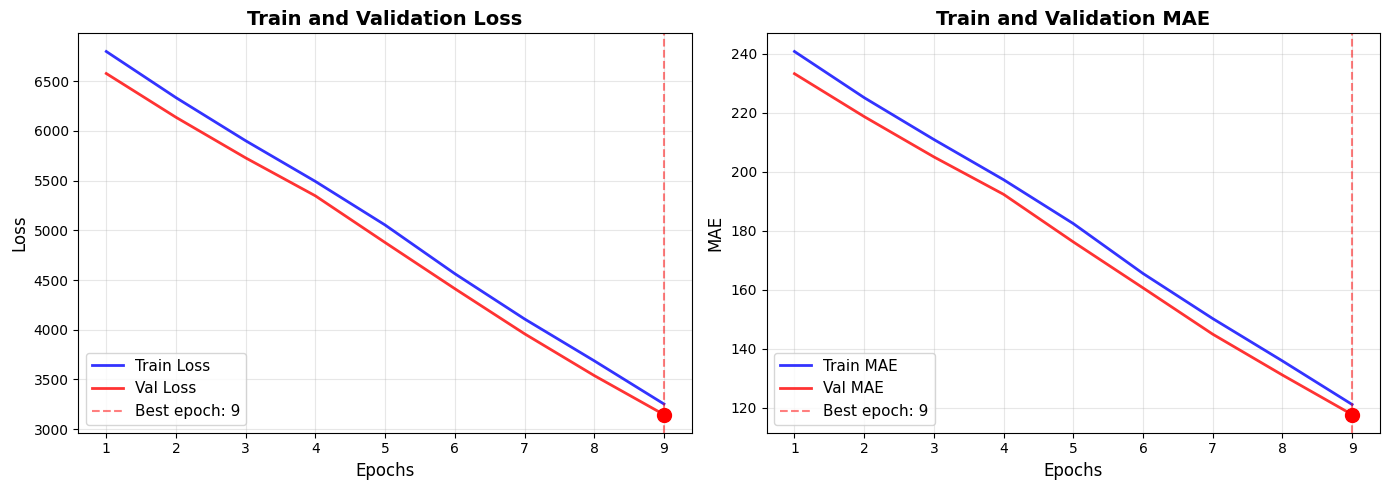


ТРЕНИРОВОЧНАЯ СТАТИСТИКА:
Финальный Train Loss: 3253.6561
Финальный Val Loss:   3147.0239
Финальный Train MAE:  121.0760
Финальный Val MAE:    117.6589

Лучшая Val Loss:     3147.0239 (эпоха 9)
Лучшая Val MAE:      117.6589 (эпоха 9)


  val epoch 10 : 100%|██████████| 8/8 [00:13<00:00,  1.68s/it, last batch loss=1710.8, last batch mae=69.0] 



GPU 0====>
total mem    : 1.95 GB
!current mem : 0.05 GB (2.4%)
reserved mem : 1.26 GB
!max per epoch: 0.88 GB (45.0%)
=====>GPU 0

total epoch 10  train loss 2958.1, val loss 2824.1 train mae 111.2, val mae 106.3
----------------------------------------


  val epoch 11 : 100%|██████████| 8/8 [00:14<00:00,  1.75s/it, last batch loss=1484.3, last batch mae=61.8] 



GPU 0====>
total mem    : 1.95 GB
!current mem : 0.05 GB (2.4%)
reserved mem : 1.26 GB
!max per epoch: 0.88 GB (45.0%)
=====>GPU 0

total epoch 11  train loss 2636.2, val loss 2569.0 train mae 100.2, val mae 98.4
----------------------------------------


  val epoch 12 : 100%|██████████| 8/8 [00:13<00:00,  1.69s/it, last batch loss=1341.8, last batch mae=57.1] 



GPU 0====>
total mem    : 1.95 GB
!current mem : 0.05 GB (2.4%)
reserved mem : 1.26 GB
!max per epoch: 0.88 GB (45.0%)
=====>GPU 0

total epoch 12  train loss 2398.5, val loss 2396.3 train mae 92.1, val mae 92.3
----------------------------------------


  val epoch 13 : 100%|██████████| 8/8 [00:13<00:00,  1.69s/it, last batch loss=1195.1, last batch mae=51.4] 



GPU 0====>
total mem    : 1.95 GB
!current mem : 0.05 GB (2.4%)
reserved mem : 1.26 GB
!max per epoch: 0.88 GB (45.0%)
=====>GPU 0

total epoch 13  train loss 2205.6, val loss 2192.5 train mae 85.6, val mae 85.3
----------------------------------------


  val epoch 14 : 100%|██████████| 8/8 [00:13<00:00,  1.74s/it, last batch loss=1104.0, last batch mae=47.9] 



GPU 0====>
total mem    : 1.95 GB
!current mem : 0.05 GB (2.4%)
reserved mem : 1.26 GB
!max per epoch: 0.88 GB (45.0%)
=====>GPU 0

total epoch 14  train loss 2007.4, val loss 2092.6 train mae 78.9, val mae 81.8
----------------------------------------


  val epoch 15 : 100%|██████████| 8/8 [00:13<00:00,  1.74s/it, last batch loss=1116.8, last batch mae=49.1] 



GPU 0====>
total mem    : 1.95 GB
!current mem : 0.05 GB (2.4%)
reserved mem : 1.26 GB
!max per epoch: 0.88 GB (45.0%)
=====>GPU 0

total epoch 15  train loss 1879.9, val loss 1981.3 train mae 74.5, val mae 78.1
----------------------------------------


train epoch 16 :  34%|███▍      | 15/44 [00:28<00:55,  1.93s/it, last batch loss=1903.5, last batch mae=75.7]


KeyboardInterrupt: 

In [12]:
train_loss_stat, val_loss_stat, train_mae_stat, val_mae_stat = [], [], [], []
for i in range(cfg.EPOCHS):
    train_epoch_loss, train_epoch_mae, val_epoch_loss, val_epoch_mae = train_one_epoch(model, train_loader, val_loader, epoch_index=i)
    train_loss_stat.append(train_epoch_loss)
    val_loss_stat.append(val_epoch_loss)
    train_mae_stat.append(train_epoch_mae)
    val_mae_stat.append(val_epoch_mae)
    if (i + 1) % 9 == 0:
        plot_training_history(train_loss_stat, val_loss_stat, train_mae_stat, val_mae_stat)